In [1]:
from alpdesign.utils import *
from alpdesign.mlp import *
from jax_unirep import get_reps
import alpdesign
import numpy as np
import matplotlib.pyplot as plt
import jax_unirep
import haiku as hk
import jax
import jax.numpy as jnp
import functools
from sklearn.decomposition import PCA

In [2]:
jnp.log(0.001)

DeviceArray(-6.9077554, dtype=float32)

In [2]:
AA_list = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V','B','Z','X','*']
blosum92 = np.loadtxt("./blosum62.txt", dtype='i', delimiter=' ')
print(blosum92)
print(len(AA_list))

[[ 4 -1 -2 -2  0 -1 -1  0 -2 -1 -1 -1 -1 -2 -1  1  0 -3 -2  0 -2 -1  0 -4]
 [-1  5  0 -2 -3  1  0 -2  0 -3 -2  2 -1 -3 -2 -1 -1 -3 -2 -3 -1  0 -1 -4]
 [-2  0  6  1 -3  0  0  0  1 -3 -3  0 -2 -3 -2  1  0 -4 -2 -3  3  0 -1 -4]
 [-2 -2  1  6 -3  0  2 -1 -1 -3 -4 -1 -3 -3 -1  0 -1 -4 -3 -3  4  1 -1 -4]
 [ 0 -3 -3 -3  9 -3 -4 -3 -3 -1 -1 -3 -1 -2 -3 -1 -1 -2 -2 -1 -3 -3 -2 -4]
 [-1  1  0  0 -3  5  2 -2  0 -3 -2  1  0 -3 -1  0 -1 -2 -1 -2  0  3 -1 -4]
 [-1  0  0  2 -4  2  5 -2  0 -3 -3  1 -2 -3 -1  0 -1 -3 -2 -2  1  4 -1 -4]
 [ 0 -2  0 -1 -3 -2 -2  6 -2 -4 -4 -2 -3 -3 -2  0 -2 -2 -3 -3 -1 -2 -1 -4]
 [-2  0  1 -1 -3  0  0 -2  8 -3 -3 -1 -2 -1 -2 -1 -2 -2  2 -3  0  0 -1 -4]
 [-1 -3 -3 -3 -1 -3 -3 -4 -3  4  2 -3  1  0 -3 -2 -1 -3 -1  3 -3 -3 -1 -4]
 [-1 -2 -3 -4 -1 -2 -3 -4 -3  2  4 -2  2  0 -3 -2 -1 -2 -1  1 -4 -3 -1 -4]
 [-1  2  0 -1 -3  1  1 -2 -1 -3 -2  5 -1 -3 -1  0 -1 -3 -2 -2  0  1 -1 -4]
 [-1 -1 -2 -3 -1  0 -2 -3 -2  1  2 -1  5  0 -2 -1 -1 -1 -1  1 -3 -1 -1 -4]
 [-2 -3 -3 -3 -2 -3 -3 -3

In [3]:
avg92 = jnp.sum(blosum92)/24/24
sum92 = 0.
for row in blosum92:
    for aa in row:
        sum92 += (aa-avg92)**2
std92 = jnp.sqrt(sum92 / 24/24)
print(avg92)
print(std92)

-1.2604167
2.166242


In [4]:
def blosum(seq1, seq2):
    seqlist1 = list(seq1)
    seqlist2 = list(seq2)
    score = 0.
    for i in range(len(seqlist1)):
        idx1 = AA_list.index(seqlist1[i])
        idx2 = AA_list.index(seqlist2[i])
        score += (blosum92[idx1][idx2] - avg92)/std92
        #jax.nn.sigmoid(score/len(seqlist1))
    return score/len(seqlist1)
    #return score/len(seqlist1)

In [5]:
target_seq = 'TARGETPEPTIDE'
oh_vec = encode_seq(list(target_seq))
oh_unirep = seq2useq(oh_vec)
target_rep = differentiable_jax_unirep(oh_unirep)

seqs = ['ISQLRYICEVIWF']

reps = get_reps(seqs)[0]
labels = []
for seq in seqs:
    labels.append(blosum(target_seq, seq))
labels = np.array(labels)

print(labels)

[0.01368617]


In [6]:
key = jax.random.PRNGKey(0)
c = alpdesign.EnsembleBlockConfig()
forward_t, full_forward_t, seq_t = alpdesign.build_e2e(c)
def gen(k, n): return jax.random.normal(key, shape=(n, 13, 20))
'''
key1, key2 = jax.random.split(key)
start_params = seq_t.init(key1, jnp.tile(
    jnp.squeeze(gen(key2, 1)), (c.model_number, 1)))
best_v, params, train_loss, bo_loss = alpdesign.alg_iter(
    key2, reps, labels, full_forward_t, seq_t, c, x0_gen=gen,
    start_params=start_params
)
'''


'\nkey1, key2 = jax.random.split(key)\nstart_params = seq_t.init(key1, jnp.tile(\n    jnp.squeeze(gen(key2, 1)), (c.model_number, 1)))\nbest_v, params, train_loss, bo_loss = alpdesign.alg_iter(\n    key2, reps, labels, full_forward_t, seq_t, c, x0_gen=gen,\n    start_params=start_params\n)\n'

In [7]:
reps = get_reps(seqs)[0]
labels = []
for seq in seqs:
    labels.append(blosum(target_seq, seq))
labels = np.array(labels)
def loop(key, reps, labels, params):
    
    #forward_t, full_forward_t, seq_t = alpdesign.build_e2e(c)
    key, key2 = jax.random.split(key)
    start_params = seq_t.init(key, jnp.tile(
    jnp.squeeze(gen(key2, 1)), (c.model_number, 1)))
    best_v, params, train_loss, bo_loss = alpdesign.alg_iter(
        key2, reps, labels, full_forward_t, seq_t, c, x0_gen=gen,
        start_params=start_params
        )
    s = decode_seq(best_v)
    reps = np.concatenate((reps, get_reps([s])[0]))
    yhat = forward_t.apply(params, key, get_reps([s])[0])
    y = blosum(target_seq, s)
    print(s, y, yhat[0], yhat[1])
    labels = np.concatenate((labels, np.array(y).reshape(1,)))
    return key, reps, labels, s, params, bo_loss, train_loss

    

In [9]:
#y = []
for i in range(50):
    print(i)
    params = None
    key, _ = jax.random.split(key, num=2)
    key, reps, labels, final_vec, params, bo_loss, mlp_loss= loop(key, reps, labels, params)
    y.append(blosum(target_seq, final_vec))

0
['D', 'K', 'E', 'S', 'W', 'H', 'M', 'R', 'A', 'I', 'V', 'Y', 'F'] 0.084706016 0.037246488 0.0040559475
1
['Y', 'I', 'T', 'I', 'N', 'M', 'D', 'C', 'K', 'C', 'M', 'M', 'A'] -0.09284363 0.017035753 0.0041701524
2
['P', 'T', 'I', 'T', 'F', 'M', 'M', 'A', 'G', 'Y', 'M', 'W', 'F'] -0.2348833 0.060898256 0.0050172256
3
['W', 'A', 'S', 'R', 'G', 'N', 'I', 'C', 'D', 'Q', 'A', 'Q', 'S'] 0.120215915 0.27405378 0.002282627
4
['W', 'Q', 'H', 'E', 'H', 'C', 'F', 'A', 'M', 'E', 'F', 'I', 'T'] -0.057333693 -0.002944249 0.008167755
5
['T', 'P', 'H', 'D', 'G', 'R', 'E', 'V', 'Q', 'L', 'S', 'T', 'E'] 0.47531512 0.31154227 0.0011455119
6
['P', 'P', 'P', 'E', 'E', 'G', 'E', 'E', 'E', 'E', 'A', 'V', 'E'] 0.58184487 0.5227841 0.018930405
7
['M', 'P', 'E', 'Q', 'V', 'G', 'G', 'R', 'E', 'T', 'T', 'K', 'E'] 0.47531512 0.50835943 0.007959515
8
['W', 'H', 'K', 'R', 'D', 'E', 'A', 'Q', 'N', 'V', 'F', 'I', 'Q'] 0.40429527 0.14115863 0.0011718702
9
['Q', 'T', 'H', 'L', 'M', 'K', 'R', 'A', 'K', 'N', 'R', 'G', 'Q'] 

Text(0.5, 1.0, 'Blosum Score vs N')

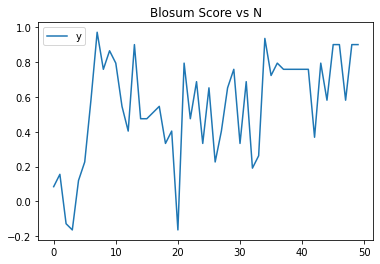

In [10]:
plt.figure()
plt.plot(y,label='y')
#plt.plot(yhat, label='yhat')
plt.legend()
plt.title('Blosum Score vs N')

In [ ]:
import pickle

with open('y.pkl', 'wb') as f1:
    pickle.dump(y, f1)
    
with open('yhat.pkl', 'wb') as f2:
    pickle.dump(yhat, f2)